In [ ]:
import os

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
analyze_path = os.path.join(parent_dir, "utils")

os.chdir(analyze_path)

要先建立輸入到模型的資料
- 若是要分類是否是熱點，應該要以一個區域的grid為單位
- 所以建立得grid亦包含該地區的所有特徵資料，以比例顯示

In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd

from utils import get_grid, calculate_gi

from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, average_precision_score, accuracy_score, f1_score

In [ ]:
dataA1 = pd.read_csv('../ComputedData/Accident/DataA1_with_MYP.csv')
dataA2 = pd.read_csv('../ComputedData/Accident/DataA2_with_MYP.csv')

filtered_A2 = dataA2[dataA2['當事者順位'] == 1]
filtered_A1 = dataA1[dataA1['當事者順位'] == 1]

filtered_A1['source'] = 'A1'
filtered_A2['source'] = 'A2'
filtered_A1['num_accidents'] = 1 
filtered_A2['num_accidents'] = 1
combined_data = pd.concat([filtered_A1, filtered_A2], ignore_index=True)

# hex_grid = get_grid(combined_data, hex_size=0.01, threshold=-1)

## obtain hotspot's county

In [ ]:
from shapely import wkt
import geopandas as gpd
import ast

taiwan = gpd.read_file('../Data/OFiles_9e222fea-bafb-4436-9b17-10921abc6ef2/TOWN_MOI_1140318.shp')
taiwan = taiwan[(~taiwan['TOWNNAME'].isin(['旗津區', '頭城鎮', '蘭嶼鄉', '綠島鄉', '琉球鄉'])) & 
                (~taiwan['COUNTYNAME'].isin(['金門縣', '連江縣', '澎湖縣']))]

TM2 = 3826
hex_grid_raw = pd.read_csv('../ComputedData/Grid/hex_grid.csv')
hex_grid_raw['geometry'] = hex_grid_raw['geometry'].apply(wkt.loads)
hex_grid = gpd.GeoDataFrame(hex_grid_raw, geometry='geometry').set_crs(TM2, allow_override=True)

grid_gi_df = pd.read_csv('../ComputedData/Grid/grid_gi.csv')
grid_gi_df['accident_indices'] = grid_gi_df['accident_indices'].apply(ast.literal_eval)
grid_gi_df['geometry'] = grid_gi_df['geometry'].apply(wkt.loads)
grid_gi  = gpd.GeoDataFrame(grid_gi_df, geometry='geometry').set_crs(TM2, allow_override=True)

taiwan_tm2 = taiwan.to_crs(TM2)

taiwan_cnty = taiwan_tm2[['COUNTYNAME','geometry']].dissolve(by='COUNTYNAME')
taiwan_cnty['geometry'] = taiwan_cnty.buffer(0)
taiwan_cnty = taiwan_cnty.reset_index()

pts = hex_grid.copy()
pts['geometry'] = pts.geometry.centroid

county_join = gpd.sjoin(
    pts[['geometry']], taiwan_cnty, how='left', predicate='within'
)[['COUNTYNAME']]

print('NaN ratio:', county_join['COUNTYNAME'].isna().mean())
grid_gi['COUNTYNAME'] = county_join['COUNTYNAME']
county_join.head()

hex_grid目前包含所有事故索引，所以要回推
- 回推方式從combined_data獲取，並且計算他們的事故特徵平均

In [ ]:
# 會造成重複的資料，因為grid可能覆蓋多個縣市
# grid = calculate_gi(6, hex_grid, adjacency='knn')
# grid = gpd.sjoin(hex_grid, taiwan[['COUNTYNAME', 'geometry']], how='left', predicate='intersects')
# grid.to_csv('../ComputedData/Grid/grid.csv', index=False)

In [ ]:
select_group = [
    # 氣候暫不討論
    # '天候名稱', '光線名稱',

    # 道路問題
    '路面狀況-路面鋪裝名稱', '路面狀況-路面狀態名稱', '路面狀況-路面缺陷名稱',
    '道路障礙-障礙物名稱', '道路障礙-視距品質名稱', '道路障礙-視距名稱',

    # 號誌
    '號誌-號誌種類名稱', '號誌-號誌動作名稱',

    # 車道劃分
    '車道劃分設施-分道設施-快車道或一般車道間名稱',
    '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱',

    # 大類別
    # '肇因研判大類別名稱-主要', '肇因研判大類別名稱-個別', # 聚焦道路類型
    # '當事者區分-類別-大類別名稱-車種', # 聚焦道路類型
    # '當事者行動狀態大類別名稱', # 聚焦道路類型
    '車輛撞擊部位大類別名稱-最初', #'車輛撞擊部位大類別名稱-其他',
    '事故類型及型態大類別名稱', '車道劃分設施-分向設施大類別名稱',
    '事故位置大類別名稱', '道路型態大類別名稱',
    
    # 子類別
    # '肇因研判子類別名稱-主要', '肇因研判子類別名稱-個別', # 聚焦道路類型
    # '當事者區分-類別-子類別名稱-車種', # 聚焦道路類型
    # '當事者行動狀態子類別名稱', # 聚焦道路類型
    # '車輛撞擊部位子類別名稱-最初', '車輛撞擊部位子類別名稱-其他', # 道路類型很大程度影響撞擊部位，所以不考慮
    # '事故類型及型態子類別名稱', '車道劃分設施-分向設施子類別名稱', 
    # '事故位置子類別名稱', '道路型態子類別名稱',

    # 其他
    # '當事者屬-性-別名稱', '當事者事故發生時年齡', 
    '速限-第1當事者', '道路類別-第1當事者-名稱',
    # '保護裝備名稱', '行動電話或電腦或其他相類功能裝置名稱', '肇事逃逸類別名稱-是否肇逃',

    # 設施
    'youbike_100m_count', 'mrt_100m_count', 'parkinglot_100m_count',

    # A1 or A2
    # 'source',
    ]

In [ ]:
def extract_features(
        grid, combined_data, select_group, rows
        ):

    indices = grid['accident_indices'].iloc[rows] # return list of original data index
    sample = combined_data.iloc[indices]
    sample = sample[select_group]

    cat_cols = sample.select_dtypes(include='object').columns
    num_cols = sample.select_dtypes(include='number').columns

    cat_features = []
    num_features = []
    # for categorical features
    if len(cat_cols) > 0:
        for col in cat_cols:
            vc = sample[col].value_counts(normalize=True)
            vc.index = [f"{col}_{v}" for v in vc.index]
            cat_features.append(vc)
        cat_features = pd.concat(cat_features)
    else:
        cat_features = pd.Series(dtype='float64')
    # for numerical features
    if len(num_cols) > 0:
        num_features = sample[num_cols].mean()
        num_features.index = [f"{col}_mean" for col in num_features.index]
    else:
        num_features = pd.Series(dtype='float64')

    all_features = pd.concat([cat_features, num_features])
    all_features_df = all_features.to_frame().T

    return all_features_df

## Features concat

In [ ]:
all_features_list = []

grid_filter = grid_gi[grid_gi['accident_indices'].str.len() > 0]
for rows in range(grid_filter.shape[0]):
    features = extract_features(grid_filter, combined_data, select_group, rows)
    all_features_list.append(features)

all_features_df = pd.concat(all_features_list, ignore_index=True)
all_features_df.fillna(0, inplace=True)

all_features_df[['mrt_100m_count_mean', 'youbike_100m_count_mean', 'parkinglot_100m_count_mean', '速限-第1當事者_mean']] =\
      all_features_df[['mrt_100m_count_mean', 'youbike_100m_count_mean', 'parkinglot_100m_count_mean', '速限-第1當事者_mean']].\
        apply(lambda x: (x - x.min()) / (x.max() - x.min()))

# all_features_df.to_csv("../ComputedData/ForModel/all_features.csv", index=False)

In [ ]:
grid_filter = grid_gi[grid_gi['accident_indices'].str.len() > 0]
all_features_df = pd.read_csv("../ComputedData/ForModel/all_features.csv")

# Model Preprocess

In [ ]:
# with county town
# 原始資料index並非從1開始所以需reset
new_grid = pd.concat([grid_filter.reset_index(drop=True)[['hotspot', 'COUNTYNAME']], all_features_df], axis=1)
county_dummies = pd.get_dummies(new_grid['COUNTYNAME'], prefix='county')
new_grid_encoded = pd.concat([new_grid.drop(['COUNTYNAME'], axis=1), county_dummies], axis=1)

# without county town
# new_grid = pd.concat([grid_filter.reset_index(drop=True)[['hotspot']], all_features_df], axis=1)
# new_grid_encoded = new_grid

# binary hotspot
new_grid_encoded['hotspot'] = new_grid_encoded['hotspot'].apply(lambda x: 'Hotspot' if 'Hotspot' in str(x) else 'Not Hotspot')

le = LabelEncoder()
y = le.fit_transform(new_grid_encoded['hotspot'])
X = new_grid_encoded.drop(columns=['hotspot'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
y_train = pd.Series(y_train, index=X_train.index)
y_test  = pd.Series(y_test,  index=X_test.index)

# with undersampling
cls_counts = y_test.value_counts()
min_count = cls_counts.min()
rus_test = RandomUnderSampler(
    sampling_strategy={int(c): int(min_count) for c in cls_counts.index},
    random_state=42
)
X_resampled_test, y_resampled_test = rus_test.fit_resample(X_test, y_test)

# without undersampling
# X_resampled_test = X_test.copy()
# y_resampled_test = y_test.copy()

print("before US")
print(pd.Series(y_test).map(dict(enumerate(le.classes_))).value_counts())
print("after US")
print(pd.Series(y_resampled_test).map(dict(enumerate(le.classes_))).value_counts())

# LR and RF

In [ ]:
lr = LogisticRegression(
        penalty='elasticnet', solver='saga', l1_ratio=0.5,
        class_weight='balanced', max_iter=1000, 
        random_state=42, 
        multi_class='multinomial'
    )
rf = RandomForestClassifier(
        n_estimators=300, max_depth=None, min_samples_leaf=1,
        class_weight='balanced', n_jobs=-1, random_state=42,
    )

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, clf in [('Logistic', lr), ('RandomForest', rf)]:
    scores = cross_val_score(clf, X_train, y_train, cv=cv, n_jobs=-1,
                            # scoring='roc_auc_ovr_weighted',
                            scoring='roc_auc'
                             )
    print(f'{name} CV ROC AUC: {scores.mean():.3f} ± {scores.std():.3f}')

lr.fit(X_train, y_train)
rf.fit(X_train, y_train)

proba_test_lr = lr.predict_proba(X_resampled_test)
proba_test_rf = rf.predict_proba(X_resampled_test)
y_pred_lr = np.argmax(proba_test_lr, axis=1)
y_pred_rf = np.argmax(proba_test_rf, axis=1)

In [ ]:
y_pred = y_pred_rf
proba_test = proba_test_rf

print("Confusion Matrix")
print(confusion_matrix(y_resampled_test, y_pred, labels=range(len(le.classes_))))

print("Classification Report")
print(classification_report(
    y_resampled_test, y_pred, target_names=le.classes_, digits=3
))

if proba_test.shape[1] == 2:
    # 二元分類
    roc_auc = roc_auc_score(y_resampled_test, proba_test[:, 1])
    print(f'ROC AUC: {roc_auc:.3f}')
    y_test_bin = label_binarize(y_resampled_test, classes=range(len(le.classes_)))
    pr_auc_macro  = average_precision_score(y_test_bin, proba_test[:, 1], average='macro')
    pr_auc_weight = average_precision_score(y_test_bin, proba_test[:, 1], average='weighted')
    print(f'PR  AUC macro: {pr_auc_macro:.3f}')
    print(f'PR  AUC wighted: {pr_auc_weight:.3f}')
else:
    # 多類分類
    roc_auc = roc_auc_score(y_resampled_test, proba_test, average='weighted', multi_class='ovr')
    print(f'ROC AUC: {roc_auc:.3f}')
    # 多類PR AUC需要 binarize 後用 one-vs-rest，再做 macro/weighted 平均
    y_test_bin = label_binarize(y_resampled_test, classes=range(len(le.classes_)))  # shape [n, n_classes]
    pr_auc_macro  = average_precision_score(y_test_bin, proba_test, average='macro')
    pr_auc_weight = average_precision_score(y_test_bin, proba_test, average='weighted')
    print(f'PR  AUC macro: {pr_auc_macro:.3f}')
    print(f'PR  AUC wighted: {pr_auc_weight:.3f}')

設施平均：該地區的事故點附近平均會有幾個設施

### RandomForest Feature Importance & LinearRegression coefficient

In [ ]:
def get_importance(model, df):
    if model.__class__.__name__ == 'LogisticRegression':
        importances = model.coef_[0]
    else:
        importances = model.feature_importances_

    indices = np.argsort(importances)[::-1]
    feature_names = df.columns

    print('feature importance')
    for i in indices:
        print(f"{feature_names[i]}: {importances[i]:.4f}")

    print('grouped feature importance')
    fi_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
    fi_df['main_feature'] = fi_df['feature'].str.split('_').str[0]
    grouped = fi_df.groupby('main_feature')['importance'].sum().sort_values(ascending=False)

    print(grouped)

get_importance(rf, X_train)
get_importance(lr, X_train)

## Neural Network

In [ ]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
INPUT_DIM = X_resampled_test.shape[1]
NUM_CLASSES = int(len(set(y)))  # 類別 0/1

class BinaryMLP(nn.Module):
    def __init__(self, in_dim=INPUT_DIM, num_classes=NUM_CLASSES, drop=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 1024),
            nn.ReLU(),
            nn.Dropout(drop),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(drop),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(drop),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(drop),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(drop),
            nn.Linear(64, num_classes)  # logits
        )
    def forward(self, x):
        return self.net(x)

In [ ]:
X_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

def to_tensors(X_df, y_arr):
    return (torch.from_numpy(np.asarray(X_df, dtype=np.float32)),
            torch.from_numpy(np.asarray(y_arr, dtype=np.int64)))

X_train_t, y_train_t = to_tensors(X_train, y_train)
X_val_t, y_val_t = to_tensors(X_val_nn, y_val_nn)
X_test_t, y_test_t = to_tensors(X_resampled_test, y_resampled_test)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=256, shuffle=True, drop_last=False)
val_loader = DataLoader(TensorDataset(X_val_t, y_val_t), batch_size=512, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=512, shuffle=False)

model = BinaryMLP().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

best_val = -np.inf
patience = 5
wait = 0
epochs = 20

def eval_loop(loader):
    model.eval()
    all_logits = []
    all_y = []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            logits = model(xb)
            all_logits.append(logits.cpu())
            all_y.append(yb)
    logits_all = torch.cat(all_logits)
    y_all = torch.cat(all_y)
    probs = torch.softmax(logits_all, dim=1).numpy()
    preds = probs.argmax(axis=1)
    acc = accuracy_score(y_all, preds)
    f1  = f1_score(y_all, preds, average='binary' if probs.shape[1]==2 else 'weighted')
    if probs.shape[1] == 2:
        auc = roc_auc_score(y_all, probs[:,1])
    else:
        auc = roc_auc_score(y_all, probs, multi_class='ovr', average='weighted')

    conf = confusion_matrix(y_all, preds, labels=range(len(le.classes_)))
    report = classification_report(y_all, preds, target_names=le.classes_, digits=3)

    return {'acc': acc, 'f1': f1, 'auc': auc, 'conf': conf, 'report': report}

In [ ]:
for epoch in range(1, epochs+1):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad(set_to_none=True)
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)

    train_loss = total_loss / len(train_loader.dataset)
    val_metrics = eval_loop(val_loader)
    print(f'Epoch {epoch:02d}/{epochs} | loss {train_loss:.4f} | '
          f'val_acc {val_metrics["acc"]:.3f} | val_f1 {val_metrics["f1"]:.3f} | val_auc {val_metrics["auc"]:.3f}')

    score_for_early = val_metrics["auc"]  # 你也可用 f1
    if score_for_early > best_val:
        best_val = score_for_early
        wait = 0
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        wait += 1
        if wait >= patience:
            print('Early stopping.')
            break


In [ ]:
model.load_state_dict(torch.load('best_model.pt'))
test_metrics = eval_loop(test_loader)
print(test_metrics['report'])

## Permutation

In [ ]:
from sklearn.metrics import average_precision_score

def build_groups_from_prefix(columns, sep="_"):
    groups = {}
    for c in columns:
        prefix = c.split(sep, 1)[0]
        groups.setdefault(prefix, []).append(c)
    return groups

def PI_ML(
        model, X_df, y, groups=None, n_repeats=5, random_state=42
        ):

    X_arr = X_df.to_numpy(copy=True)
    name_to_idx = {c: i for i, c in enumerate(X_df.columns)}
    if groups is None:
        idx_groups = {c: [i] for i, c in enumerate(X_df.columns)}
    else:
        idx_groups = {g: [name_to_idx[c] for c in cols] for g, cols in groups.items()}

    def get_ap(proba):
        # 二元：取正類；多類：取第二欄 (假設 label encoder 對應)
        if proba.ndim == 2 and proba.shape[1] > 1:
            target_scores = proba[:, 1]
        else:
            target_scores = proba
        return average_precision_score(y, target_scores)

    rng = np.random.RandomState(random_state)
    base = get_ap(model.predict_proba(X_arr))
    n_samples = X_arr.shape[0]
    X_work = X_arr.copy()

    rows = []
    for gname, cols in idx_groups.items():
        original = X_work[:, cols].copy()
        losses = []
        for _ in range(n_repeats):
            perm_idx = rng.permutation(n_samples)
            X_work[:, cols] = original[perm_idx, :]
            score = get_ap(model.predict_proba(X_work))
            losses.append(base - score)
            X_work[:, cols] = original  # restore
        rows.append((gname, float(np.mean(losses)), float(np.std(losses))))

    out = pd.DataFrame(rows, columns=["group", "importance", "std"])\
             .sort_values("importance", ascending=False)\
             .reset_index(drop=True)
    return base, out

def PI_NN(model, X_df, y, groups=None, n_repeats=5, random_state=42):

    X_arr = X_df.to_numpy(copy=True)
    name_to_idx = {c: i for i, c in enumerate(X_df.columns)}
    if groups is None:
        idx_groups = {c: [i] for i, c in enumerate(X_df.columns)}
    else:
        idx_groups = {g: [name_to_idx[c] for c in cols] for g, cols in groups.items()}

    def get_ap(model, X_work):

        Xt = torch.from_numpy(np.asarray(X_work,  dtype=np.float32))
        yt = torch.from_numpy(np.asarray(y, dtype=np.int64))
        logits_val = model(Xt.to(device))
        # 回傳最大值所在位置
        preds_val = logits_val.argmax(dim=-1)
        acc_val = (preds_val.cpu() == yt).float().mean().item()
        return acc_val

    rng = np.random.RandomState(random_state)
    base = get_ap(model, X_arr)
    n_samples = X_arr.shape[0]
    X_work = X_arr.copy()

    rows = []
    for gname, cols in idx_groups.items():
        original = X_work[:, cols].copy()
        losses = []
        for _ in range(n_repeats):
            perm_idx = rng.permutation(n_samples)
            X_work[:, cols] = original[perm_idx, :]
            score = get_ap(model, X_work)
            losses.append(base - score)
            X_work[:, cols] = original  # restore
        rows.append((gname, float(np.mean(losses)), float(np.std(losses))))

    out = pd.DataFrame(rows, columns=["group", "importance", "std"])\
             .sort_values("importance", ascending=False)\
             .reset_index(drop=True)
    return base, out


In [ ]:
groups = build_groups_from_prefix(X_test.columns)

In [ ]:
base_ap, gperm = PI_ML(lr, X_test, y_test, groups=groups, n_repeats=30)

In [ ]:
base_ap, gperm = PI_NN(model, X_test, y_test, groups=groups, n_repeats=30)

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = ['Arial Unicode Ms']

gperm.sort_values('importance', ascending=True, inplace=True)
plt.figure(figsize=(16, 15))
plt.errorbar(
    gperm['importance'], gperm['group'], 
    xerr=gperm['std'], fmt='o', linewidth=2, capsize=5
)
plt.title('GPerm Feature Importance with Std')
plt.tight_layout()
plt.show()

# Hitrate
le的轉換是1為not hotspot

In [97]:
county_cols = [col for col in X_test.columns if col.startswith('county_')]

df_hitrate = X_resampled_test.copy()
df_hitrate['y_true'] = y_resampled_test
df_hitrate['y_pred'] = y_pred_lr

hitrate = {}
for col in county_cols:

    mask = df_hitrate[df_hitrate[col] != False]
    tn, fp, fn, tp = confusion_matrix(
        mask['y_true'], mask['y_pred'], labels=[1, 0] # 這裡0是Hotspot
    ).ravel()

    # calculate precision, recall, accuracy, f1-score
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    hitrate[col] = {
        'precision': precision,
        'recall': recall,
        'accuracy': accuracy,
        'f1': f1
    }

hitrate_df = pd.DataFrame.from_dict(hitrate, orient='index', columns=['precision', 'recall', 'accuracy', 'f1']).sort_values('f1', ascending=False)
hitrate_df['county'] = hitrate_df.index
hitrate_df['county'] = hitrate_df['county'].str.replace('county_', '')

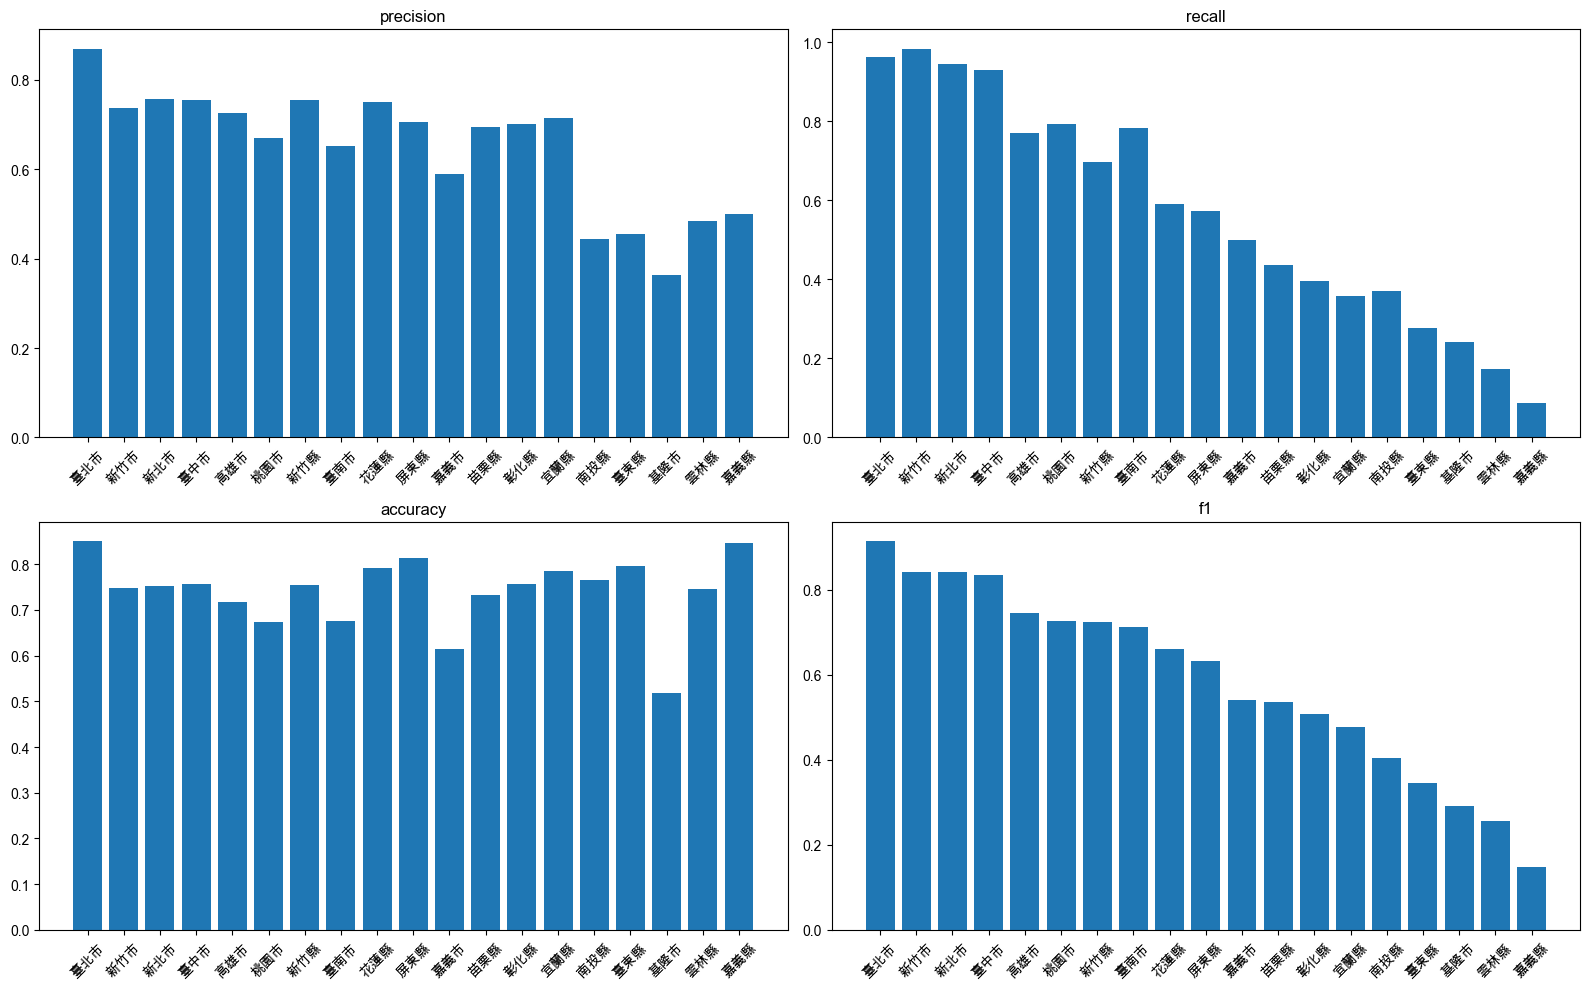

In [98]:
# sort the columns before plot
plt.figure(figsize=(16, 10))
for col in ['precision', 'recall', 'accuracy', 'f1']:
    plt.subplot(2, 2, ['precision', 'recall', 'accuracy', 'f1'].index(col) + 1)
    plt.bar(hitrate_df['county'], hitrate_df[col])
    plt.title(col)
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()